In [1]:
import numpy as np
import pandas as pd
import openml
import pickle
import os
import sys
from meta_model.utils import ndcg_sim, ndcg, custom_sim, load_meta_dataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

BENCHMARK_RESULTS_DIR = "meta_dataset_creation/data/benchmark_results/"
META_FEATURES_FILE = "meta_dataset_creation/data/meta_features/original/meta_features.csv"

dataset_statistics = ["n_instances", "n_features",
                        "dim", "num_on_cat", "n_num_att", "n_cat_att"]

attributes_statistics = [
    f"{p}_{name}" for p in ["min", "q1", "mean", "q3", "max"] for name in [
        "means_num_att", "std_num_att",
        "card_cat_att", "entropy_cat_att",
        "covariance",
    ]
]

baseline_pairs = {
    "haverage": "manhattan_hamming",
    "fasterpam": "euclidean_hamming",
    "kprototypes": "sqeuclidean_hamming",
}

names = {
    "haverage": "H-AVG",
    "fasterpam": "K-MED",
    # "spectral": "Spectral",
    "kprototypes": "K-PROTO",
}

In [2]:
import openml

openml_df = openml.datasets.list_datasets(output_format="dataframe")
df = openml_df[openml_df.NumberOfNumericFeatures >= 1]
df = df[df.NumberOfSymbolicFeatures >= 2]
df = df[df.NumberOfInstances >= 30]
df = df[df.NumberOfMissingValues <= 0.1 *
        df.NumberOfFeatures*df.NumberOfInstances]
df = df[df.NumberOfClasses >= 2]
df = df[df.version == 1]
dict_ = {"NumberOfFeatures":"Features", "NumberOfInstances": "Instances", "NumberOfNumericFeatures":"Num. Features", "NumberOfSymbolicFeatures": "Cat. Features", "NumberOfClasses": "Classes"}
df= df.rename(columns=dict_)

dataset_list = [int(filename.split('.')[0])
                           for filename in os.listdir("meta_dataset_creation/data/benchmark_results/kprototypes/original/scores/")]

df[df.did.isin(dataset_list)][dict_.values()].describe().astype(int)

,Features,Instances,Num. Features,Cat. Features,Classes
count,110,110,110,110,110
mean,33,146456,18,14,4
std,46,697313,39,19,5
min,3,36,1,2,2
25%,11,303,6,3,2
50%,20,1227,7,8,3
75%,32,5880,19,21,4
max,300,5100000,294,137,48


In [30]:
train_res_dir = "meta_model/data/training_final/"
train_res = {}
for name in os.listdir(train_res_dir):
    algorithm, eval_metric = name.split('.')[0].split('_')
    print(algorithm, eval_metric)
    if algorithm not in train_res:
        train_res[algorithm] = {}
    filename = os.path.join(train_res_dir, name)
    with open(filename, "rb") as f:
        train_res[algorithm][eval_metric] = pickle.load(f)
        mixed_meta_df, benchmark_results = train_res[algorithm][eval_metric]["meta_dataset"]
        print(mixed_meta_df.shape, benchmark_results.shape)
        Y = benchmark_results.to_numpy()
        if eval_metric in ["acc", "purity"]:
            Yn = np.array([y/max(y) for y in Y])
            # Yn[Yn > 0] **= 4
            Yn[Yn <= 0] = -1
        elif eval_metric == "ari":
            Yn = np.array([(y+0.5)/max(y+0.5) for y in Y])
            Yn[Yn <= 0] = -1
        else:
            Yn = np.array([(y+1)/max(y+1) for y in Y])
            Yn[Yn <= 0] = -1
        X = mixed_meta_df.to_numpy()
        sc = StandardScaler().fit(X)
        X = sc.transform(X)
        X2 = X[:, [i for i in range(X.shape[1]) if mixed_meta_df.columns.values[i] in dataset_statistics+attributes_statistics]]
        train_res[algorithm][eval_metric]["Y"] = Y
        train_res[algorithm][eval_metric]["Yn"] = Yn
        train_res[algorithm][eval_metric]["X"] = X
        train_res[algorithm][eval_metric]["X2"] = X2
        # print(train_res[algorithm][eval_metric]["train_results"]["AMF-FS-KNN"])
        selected_feats = train_res[algorithm][eval_metric]["train_results"]["AMF-FS-KNN"]["selected_features"]
        selected_feats2 = train_res[algorithm][eval_metric]["train_results"]["LMF-FS-KNN"]["selected_features"]
        train_res[algorithm][eval_metric]["selected_features"] = mixed_meta_df.columns.to_numpy()[selected_feats]
        train_res[algorithm][eval_metric]["selected_features2"] = np.array([col for col in mixed_meta_df.columns if col in dataset_statistics+attributes_statistics])[selected_feats2]

kprototypes sil
(170, 61) (170, 120)
kprototypes ari
(85, 61) (85, 120)
kprototypes acc
(85, 61) (85, 120)
fasterpam sil
(173, 61) (173, 120)
fasterpam ari
(81, 61) (81, 120)
fasterpam acc
(81, 61) (81, 120)
haverage sil
(173, 61) (173, 120)
haverage ari
(94, 61) (94, 120)
haverage acc
(94, 61) (94, 120)


In [4]:
# def load_data(algorithm, eval_metric):
#     scores_dir = os.path.join(BENCHMARK_RESULTS_DIR, algorithm, "original/scores")
#     mixed_meta_df, benchmark_results = load_meta_dataset(META_FEATURES_FILE, scores_dir, algorithm, eval_metric)

#     index = benchmark_results.index
#     Y = benchmark_results[index.isin(mixed_meta_df.index)].to_numpy()
#     if eval_metric in ["acc", "purity"]:
#         Yn = np.array([y/max(y) for y in Y])
#         # Yn[Yn > 0] **= 4
#         Yn[Yn <= 0] = -1
#     elif eval_metric == "ari":
#         Yn = np.array([(y+0.5)/max(y+0.5) for y in Y])
#         Yn[Yn <= 0] = -1
#     else:
#         Yn = np.array([(y+1)/max(y+1) for y in Y])
#         Yn[Yn <= 0] = -1
#     X = mixed_meta_df.loc[[i for i in index if i in mixed_meta_df.index]].to_numpy()
#     sc = StandardScaler().fit(X)
#     X = sc.transform(X)
#     X2 = X[:, [i for i in range(X.shape[1]) if mixed_meta_df.columns.values[i] in dataset_statistics+attributes_statistics]]
#     return X, X2, Y, Yn, mixed_meta_df.columns.values, [col for col in mixed_meta_df.columns.values if col in dataset_statistics+attributes_statistics], benchmark_results.columns.values

In [31]:
results = {}
for algorithm in train_res:
    results[algorithm] = {}
    for eval_metric in train_res[algorithm]:
        print(algorithm, eval_metric)
        results[algorithm][eval_metric] = {}
        Y = train_res[algorithm][eval_metric]["Y"]
        Yn = train_res[algorithm][eval_metric]["Yn"]

        ndcg_ranks = [1, 3, 5, 10, 15, 20]
        n_bests = [1, 3, 5, 10]
        ndcg_scores = {
            model_name: {p: np.zeros(X.shape[0]) for p in ndcg_ranks}
            for model_name in train_res[algorithm][eval_metric]["train_results"]
        } #| {'ensemble': {p: np.zeros(meta_X.shape[0]) for p in ndcg_ranks}}

        lb_scores = np.zeros(X.shape[0])
        rb_scores = {k: np.zeros(X.shape[0]) for k in n_bests}
        mb_scores = np.zeros(X.shape[0])
        model_scores = {
            model_name: {k: np.zeros(X.shape[0]) for k in n_bests}
            for model_name in train_res[algorithm][eval_metric]["train_results"]
        } #| {'ensemble': {k: np.zeros(len(test_index)) for k in n_bests}}

        for name, obj in train_res[algorithm][eval_metric]["train_results"].items():
            Y_pred = obj["pred"]
            for p in ndcg_ranks:
                ndcg_scores[name][p] = ndcg(Yn, Y_pred, p=p)
            for k in n_bests:
                model_scores[name][k] = np.array(
                    [max(y[y > -1][np.argsort(-Y_pred[i][y > -1])[:k]]) for i, y in enumerate(Y)])
        for k in n_bests:
            rb_scores[k] = np.array(
                [max(np.random.choice(y[y > -1], k)) for y in Y])
    
        benchmark_results = train_res[algorithm][eval_metric]["meta_dataset"][1]
        similarity_pairs = benchmark_results.columns.values
        sim_pairs_index = dict(zip(similarity_pairs, range(len(similarity_pairs))))
        lb_scores = Y[:, sim_pairs_index[baseline_pairs[algorithm]]]
        mb_scores = np.max(Y, axis=1)

        results[algorithm][eval_metric]["scores"] = model_scores
        results[algorithm][eval_metric]["scores"]["LB"] = {1: lb_scores}
        results[algorithm][eval_metric]["scores"]["RB"] = rb_scores
        results[algorithm][eval_metric]["scores"]["Oracle"] = {1: mb_scores}
        results[algorithm][eval_metric]["ndcg"] = ndcg_scores

kprototypes sil
kprototypes ari
kprototypes acc
fasterpam sil
fasterpam ari
fasterpam acc
haverage sil
haverage ari
haverage acc


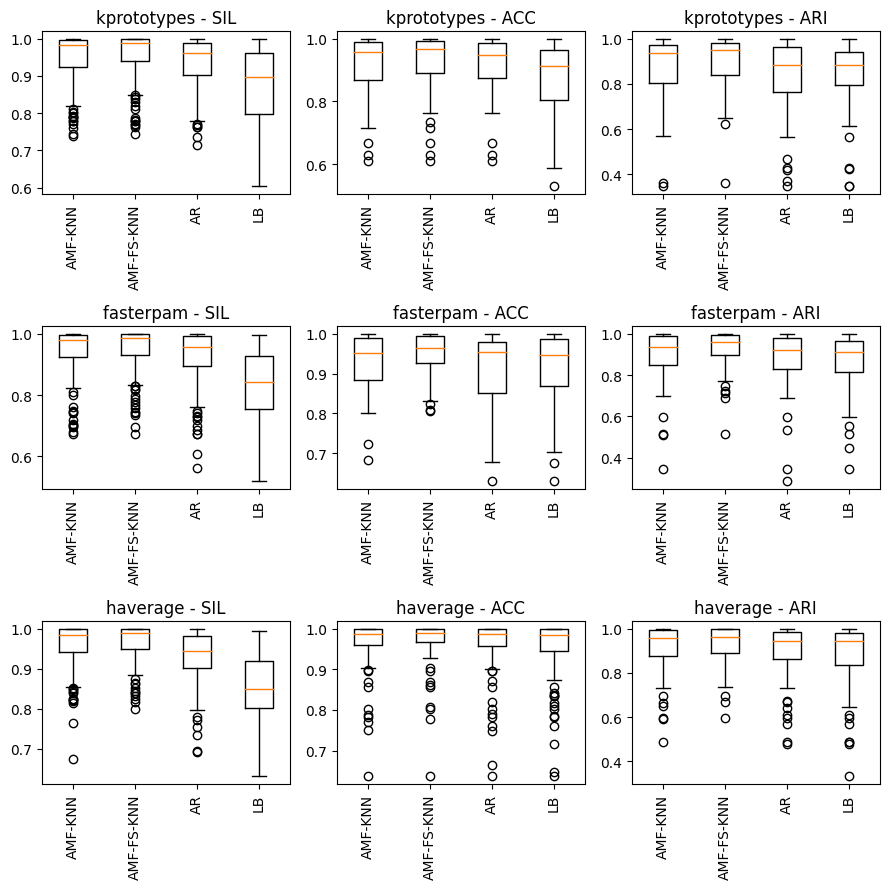

In [6]:
rows, cols = 3, 3
model_names = ["AMF-KNN", "AMF-FS-KNN", "AR", "LB"]
plt.figure(figsize=(cols*3, rows*3))
i = 1
for algorithm in results:
    for eval_metric in ["sil", "acc", "ari"]:
        y = {}
        best_scores = results[algorithm][eval_metric]["scores"]["Oracle"][1]
        lb_scores = results[algorithm][eval_metric]["scores"]["LB"][1]
        for name in model_names:
            l = results[algorithm][eval_metric]["scores"][name][1]
            if eval_metric in ["sil"]:
                y[name] = (l+1)/(best_scores+1)
            elif eval_metric in ["acc"]:
                y[name] = (l)/(best_scores)
            elif eval_metric in ["ari"]:
                y[name] = (l+0.5)/(best_scores+0.5)
            # y[name] = (l-lb_scores)
        plt.subplot(rows, cols, i)
        # print(list(y.values())[0])
        plt.boxplot(y.values(), labels=y.keys())
        plt.title(f"{algorithm} - {eval_metric.upper()}")
        plt.xticks(rotation="vertical")
        i += 1
plt.tight_layout()
plt.show()

In [7]:
model_names = ["AR", "AMF-FS-KNN"]
for eval_metric in ["sil", "acc", "ari"]:
    obj = {}
    print(f"top-k {eval_metric} for different values of k")
    for algorithm in results:
        Y = train_res[algorithm][eval_metric]["Y"]
        best_scores = results[algorithm][eval_metric]["scores"]["Oracle"][1]
        for name in ["LB", "RB"]:
            if name not in obj:
                obj[name] = {}
            l = results[algorithm][eval_metric]["scores"][name][1]
            if eval_metric in ["sil"]:
                y[name] = (l+1)/(best_scores+1)
            elif eval_metric in ["acc"]:
                y[name] = (l)/(best_scores)
            elif eval_metric in ["ari"]:
                y[name] = (l+0.5)/(best_scores+0.5)
            obj[name][f"({algorithm[0]}) top-01"] = \
                f"{np.format_float_positional(np.mean(l), 3)}±{np.format_float_positional(np.std(l), 2)}"

        for model_name in model_names:
            if model_name not in obj:
                obj[model_name] = {}
            for k in [1, 10]:
                l = results[algorithm][eval_metric]["scores"][model_name][k]
                if eval_metric in ["sil"]:
                    y[name] = (l+1)/(best_scores+1)
                elif eval_metric in ["acc"]:
                    y[name] = (l)/(best_scores)
                elif eval_metric in ["ari"]:
                    y[name] = (l+0.5)/(best_scores+0.5)
                obj[model_name][f"({algorithm[0]}) top-{k:02d}"] = \
                    f"{np.format_float_positional(np.mean(l), 3)}±{np.format_float_positional(np.std(l), 2)}"

            # for p in [5, 10]:
            #     l = results[algorithm][eval_metric]["ndcg"][model_name][p]
            #     obj[model_name][f"({algorithm[0]}) ndcg@{k:02d}"] = \
            #         f"{np.format_float_positional(np.mean(l), 3)}±{np.format_float_positional(np.std(l), 2)}"

    print(pd.DataFrame.from_dict(obj, orient="index")[sorted(obj["AR"])])
    print()

top-k sil for different values of k
            (f) top-01  (f) top-10  (h) top-01  (h) top-10  (k) top-01  \
LB          0.417±0.23         NaN   0.519±0.2         NaN  0.473±0.23   
RB          0.431±0.23         NaN  0.547±0.21         NaN  0.457±0.23   
AR          0.574±0.23  0.641±0.22  0.654±0.19  0.724±0.19   0.570±0.2   
AMF-FS-KNN  0.615±0.21  0.657±0.20  0.724±0.19  0.744±0.18  0.614±0.21   

            (k) top-10  
LB                 NaN  
RB                 NaN  
AR          0.626±0.20  
AMF-FS-KNN   0.642±0.2  

top-k acc for different values of k
            (f) top-01 (f) top-10  (h) top-01  (h) top-10  (k) top-01  \
LB          0.751±0.10        NaN   0.793±0.1         NaN  0.721±0.12   
RB          0.743±0.11        NaN  0.778±0.11         NaN  0.728±0.11   
AR          0.749±0.11  0.78±0.09  0.801±0.10  0.823±0.09  0.755±0.10   
AMF-FS-KNN  0.782±0.10  0.798±0.1  0.809±0.09  0.818±0.09  0.766±0.10   

           (k) top-10  
LB                NaN  
RB               

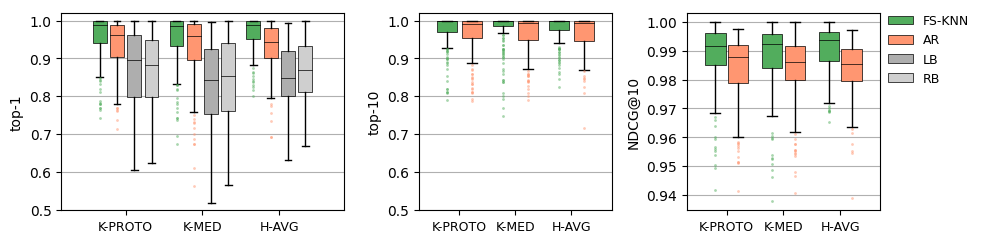

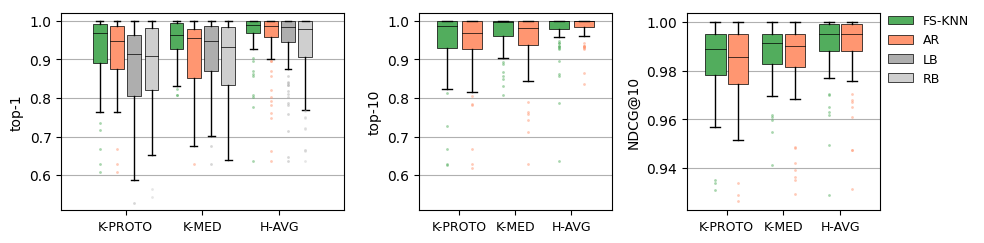

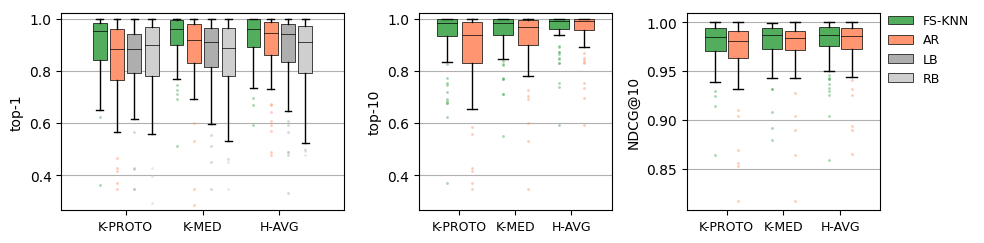

In [8]:
def show_scores(results, savedir=None):
    colors = {
        "AMF-FS-KNN": "#52AD5D",
        # "AMF-AE-KNN": "#FF9671",
        "AR": "#FF9671",
        # "AR": "#868686",
        "LB": "#AEAEAE",
        "RB": "#CFCFCF",
    }
    labels = {k: k for k in colors}
    labels["AMF-FS-KNN"] = "FS-KNN"
    # labels["AMF-AE-KNN"] = "AE-KNN"

    model_names = ["AMF-FS-KNN", "AR"] #, "MKNN", "MDTree", "PR-LR", "PR-KNN", "PR-DTree"
    for eval_metric in ["sil", "acc", "ari"]:
        fig = plt.figure(figsize=(9, 2.5))
        
        plt.subplot(1, 10, (1, 4))
        k = 1
        baselines = ["LB", "RB"]
        y = {}
        min_ = 1
        for algorithm in results:
            res = results[algorithm][eval_metric]["scores"]
            best_scores = res["Oracle"][1]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                l = res[model_name][k]
                if eval_metric in ["sil"]:
                    v = (l+1)/(best_scores+1)
                elif eval_metric in ["acc"]:
                    v = (l)/(best_scores)
                elif eval_metric in ["ari"]:
                    v = (l+0.5)/(best_scores+0.5)
                y[model_name].append(v)

            for name in baselines:
                if name not in y:
                    y[name] = []
                l = res[name][1]
                if eval_metric in ["sil"]:
                    v = (l+1)/(best_scores+1)
                elif eval_metric in ["acc"]:
                    v = (l)/(best_scores)
                elif eval_metric in ["ari"]:
                    v = (l+0.5)/(best_scores+0.5)
                y[name].append(v)

        n_bar = len(y)
        w = 0.9/n_bar
        x = np.arange(len(results))
        boxes = []
        i = 0
        for model_name, values in y.items():
            min_ = min(min_, min(min(val) for val in values))          
            boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.8*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            boxes.append(b)
            i+=1
        plt.ylabel(f"top-{k}")
        plt.ylim((min_-0.02, 1.02))
        plt.xticks(x, [names[algo] for algo in results], rotation=0, fontsize=9)
        plt.grid(axis="y")
        
        plt.subplot(1, 10, (5, 7))
        k = 10
        y = {}
        for algorithm in results:
            res = results[algorithm][eval_metric]["scores"]
            best_scores = res["Oracle"][1]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                l = res[model_name][k]
                if eval_metric in ["sil"]:
                    v = (l+1)/(best_scores+1)
                elif eval_metric in ["acc"]:
                    v = (l)/(best_scores)
                elif eval_metric in ["ari"]:
                    v = (l+0.5)/(best_scores+0.5)
                y[model_name].append(v)

        n_bar = len(y)
        w = 0.9/n_bar
        x = np.arange(len(results))
        i = 0
        for model_name, values in y.items():            
            boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.8*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            i+=1
        plt.ylabel(f"top-{k}")
        plt.ylim((min_-0.02, 1.02))
        plt.xticks(x, [names[algo] for algo in results], rotation=0, fontsize=9)
        plt.grid(axis="y")
        
        plt.subplot(1, 10, (8, 10))
        k = 10
        y = {}
        for algorithm in results:
            res = results[algorithm][eval_metric]["ndcg"]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                v = res[model_name][k]
                y[model_name].append(v)

        n_bar = len(y)
        w = 0.8/n_bar
        x = np.arange(len(results))
        i = 0
        for model_name, values in y.items():            
            boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.9*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            i+=1
        plt.ylabel(f"NDCG@{k}")
        plt.xticks(x, [names[algo] for algo in results], rotation=0, fontsize=9)
        plt.grid(axis="y")
        
        # if eval_metric=="sil":
        #     plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=10, loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=len(model_names)+len(baselines))
        plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=9, loc= "upper left", bbox_to_anchor= (0.98, 0.98), frameon=False)

        plt.tight_layout()
        # if savedir is not None:
        #     plt.savefig(os.path.join(savedir, f"results_{eval_metric}.pdf"), bbox_inches='tight')
        plt.show()

show_scores(results, savedir="imgs/")

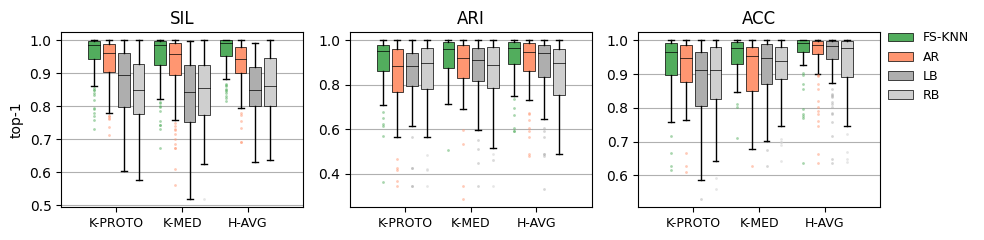

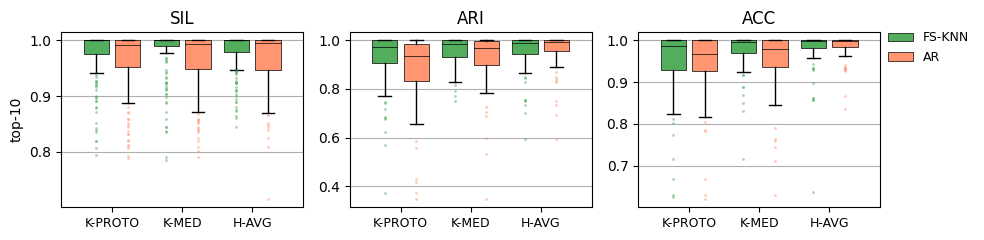

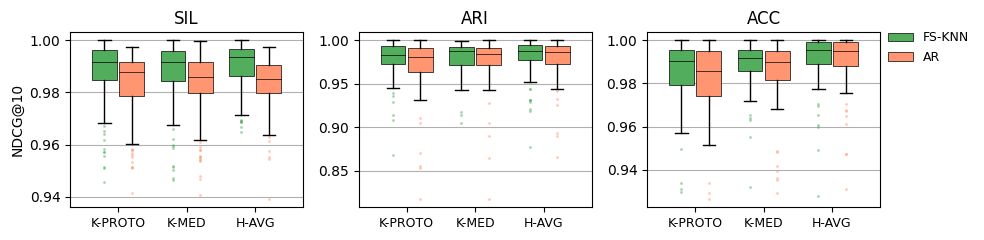

In [35]:
def show_scores(results, savedir=None):
    colors = {
        "AMF-FS-KNN": "#52AD5D",
        # "AMF-AE-KNN": "#FF9671",
        "AR": "#FF9671",
        # "AR": "#868686",
        "LB": "#AEAEAE",
        "RB": "#CFCFCF",
    }
    labels = {k: k for k in colors}
    labels["AMF-FS-KNN"] = "FS-KNN"
    # labels["AMF-AE-KNN"] = "AE-KNN"

    model_names = ["AMF-FS-KNN", "AR"] #, "MKNN", "MDTree", "PR-LR", "PR-KNN", "PR-DTree"

    fig = plt.figure(figsize=(9, 2.5))
    k = 1
    baselines = ["LB", "RB"]
    for j, eval_metric in enumerate(["sil", "ari", "acc"]):
        y = {}
        plt.subplot(1, 3, j+1)
        for algorithm in results:
            res = results[algorithm][eval_metric]["scores"]
            best_scores = res["Oracle"][1]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                l = res[model_name][k]
                if eval_metric in ["sil"]:
                    v = (l+1)/(best_scores+1)
                elif eval_metric in ["acc"]:
                    v = (l)/(best_scores)
                elif eval_metric in ["ari"]:
                    v = (l+0.5)/(best_scores+0.5)
                y[model_name].append(v)

            for name in baselines:
                if name not in y:
                    y[name] = []
                l = res[name][1]
                if eval_metric in ["sil"]:
                    v = (l+1)/(best_scores+1)
                elif eval_metric in ["acc"]:
                    v = (l)/(best_scores)
                elif eval_metric in ["ari"]:
                    v = (l+0.5)/(best_scores+0.5)
                y[name].append(v)

        n_bar = len(y)
        w = 0.9/n_bar
        x = np.arange(len(results))
        boxes = []
        i = 0
        for model_name, values in y.items():
            # min_ = min(min_, min(min(val) for val in values))          
            boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.8*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            boxes.append(b)
            i+=1
        if j==0: plt.ylabel(f"top-{k}")
        # plt.ylim((min_-0.02, 1.02))
        plt.xticks(x, [names[algo] for algo in results], rotation=0, fontsize=9)
        plt.grid(axis="y")
        plt.title(eval_metric.upper())
    plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=9, loc= "upper left", bbox_to_anchor= (0.98, 0.9), frameon=False)
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(os.path.join(savedir, f"results_top{k}.pdf"), bbox_inches='tight')
    plt.show()
        
    fig = plt.figure(figsize=(9, 2.5))
    k = 10
    for j, eval_metric in enumerate(["sil", "ari", "acc"]):
        y = {}
        plt.subplot(1, 3, j+1)
        for algorithm in results:
            res = results[algorithm][eval_metric]["scores"]
            best_scores = res["Oracle"][1]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                l = res[model_name][k]
                if eval_metric in ["sil"]:
                    v = (l+1)/(best_scores+1)
                elif eval_metric in ["acc"]:
                    v = (l)/(best_scores)
                elif eval_metric in ["ari"]:
                    v = (l+0.5)/(best_scores+0.5)
                y[model_name].append(v)

        n_bar = len(y)
        w = 0.9/n_bar
        x = np.arange(len(results))
        boxes = []
        i = 0
        for model_name, values in y.items():            
            boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.8*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            boxes.append(b)
            i+=1
        if j==0: plt.ylabel(f"top-{k}")
        # plt.ylim((min_-0.02, 1.02))
        plt.xticks(x, [names[algo] for algo in results], rotation=0, fontsize=9)
        plt.grid(axis="y")
        plt.title(eval_metric.upper())
    plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=9, loc= "upper left", bbox_to_anchor= (0.98, 0.9), frameon=False)
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(os.path.join(savedir, f"results_top{k}.pdf"), bbox_inches='tight')
    plt.show()
        
    fig = plt.figure(figsize=(9, 2.5))
    for j, eval_metric in enumerate(["sil", "ari", "acc"]):
        y = {}
        plt.subplot(1, 3, j+1)
        for algorithm in results:
            res = results[algorithm][eval_metric]["ndcg"]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                v = res[model_name][k]
                y[model_name].append(v)

        n_bar = len(y)
        w = 0.8/n_bar
        x = np.arange(len(results))
        boxes = []
        i = 0
        for model_name, values in y.items():            
            boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
                            linewidth=0)
            medianprops = dict(color='black', linewidth=0.5)
            meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            b = plt.boxplot(values, positions=x+(i*w-(n_bar-1)*w/2), widths=0.9*w,  patch_artist=True, boxprops=boxprops, flierprops=flierprops, medianprops=medianprops, showcaps=True, showfliers=True)
            boxes.append(b)
            i+=1
        if j==0: plt.ylabel(f"NDCG@{k}")
        plt.xticks(x, [names[algo] for algo in results], rotation=0, fontsize=9)
        plt.grid(axis="y")
        plt.title(eval_metric.upper())
        
        # if eval_metric=="sil":
        #     plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=10, loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=len(model_names)+len(baselines))
    plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=9, loc= "upper left", bbox_to_anchor= (0.98, 0.9), frameon=False)
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(os.path.join(savedir, f"results_ndcg{k}.pdf"), bbox_inches='tight')
    plt.show()

show_scores(results) #, savedir="imgs/"

[57, 56, 57]
[58, 57, 58]
[58, 57, 58]


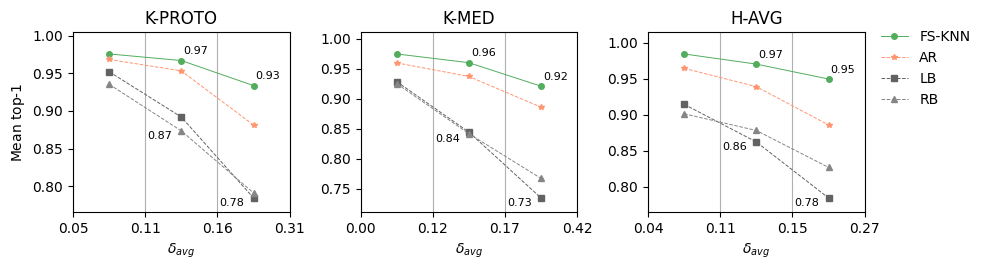

[29, 28, 28]
[27, 27, 27]
[32, 31, 31]


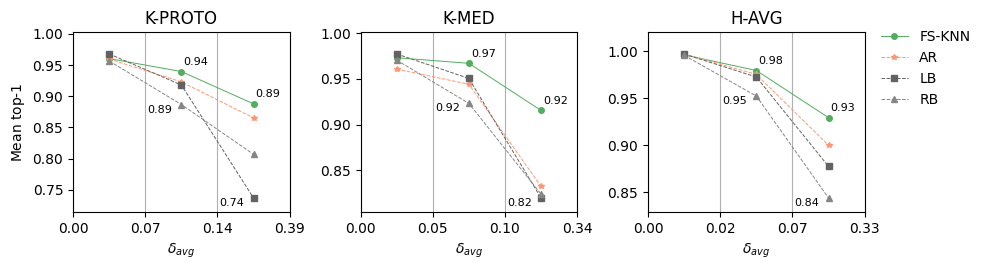

[29, 28, 28]
[27, 27, 27]
[32, 31, 31]


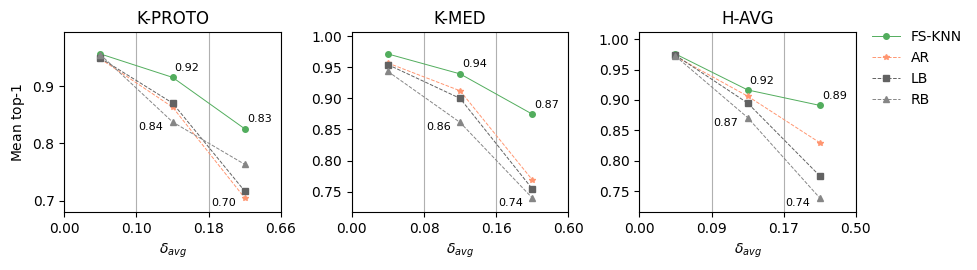

In [10]:
def show_results_delta(results, eval_metric="sil", savedir=None, list_algo=None):
    model_names = ["AMF-FS-KNN", "AR"]
    colors = {
        "AMF-FS-KNN": "#52AD5D",
        "AR": "#FF9671",
        "LB": "#626262",
        "RB": "#868686",
        # "AR": "#AFAFAF"
    }

    linestyle = {
        "AMF-FS-KNN": "-o",
        "AR": "--*",
        "LB": "--s",
        "RB": "--^"
    }
    labels = {k: k for k in colors}
    labels["AMF-FS-KNN"] = "FS-KNN"

    for eval_metric in ["sil", "acc", "ari"]:
        plt.figure(figsize=(3*3, 2.8))
        j = 1
        for algorithm in results:
            plt.subplot(1, 3, j)
            Y = train_res[algorithm][eval_metric]["Y"]
            if eval_metric in ["acc", "purity"]:
                Yn = np.array([y/max(y) for y in Y])
                # Yn[Yn > 0] **= 4
                Yn[Yn <= 0] = -1
            elif eval_metric == "ari":
                Yn = np.array([(y+0.5)/max(y+0.5) for y in Y])
                Yn[Yn <= 0] = -1
            else:
                Yn = np.array([(y+1)/max(y+1) for y in Y])
                Yn[Yn <= 0] = -1

            res = results[algorithm][eval_metric]["scores"]
            
            best_scores = res["Oracle"][1]
            lb_scores = res["LB"][1]
            l = [np.mean(1 - y[y>-1]) for i, y in enumerate(Yn)]
            x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 4)])
            
            x[0] -= 1e-4
            diff = 0.025
            list_indices = [
                [xr < np.mean(1 - y[y>-1]) <= x[r+1] for i, y in enumerate(Yn)]
                for r, xr in enumerate(x[:-1])
            ] #

            k=1
            baselines = ["LB", "RB"]
            y = {}
            yerr = {}
            print([sum(indices) for indices in list_indices])
            for model_name in model_names:
                y[model_name] = []
                yerr[model_name] = []
                scores = res[model_name][k]
                for i, indices in enumerate(list_indices):
                    if eval_metric in ["sil"]:
                        ln = ((scores+1)/(best_scores+1))[indices]
                    elif eval_metric in ["ari"]:
                        ln = ((scores+0.5)/(best_scores+0.5))[indices]
                    else:
                        ln = (scores/best_scores)[indices]
                    v = np.mean(ln)
                    std = np.std(ln)
                    y[model_name].append(v)
                    yerr[model_name].append(std)

            for name in baselines:
                y[name] = []
                yerr[name] = []
                scores = res[name][1]
                for i, indices in enumerate(list_indices):
                    if eval_metric in ["sil"]:
                        ln = ((scores+1)/(best_scores+1))[indices]
                    elif eval_metric in ["ari"]:
                        ln = ((scores+0.5)/(best_scores+0.5))[indices]
                    else:
                        ln = (scores/best_scores)[indices]
                    v = np.mean(ln)
                    std = np.std(ln)
                    y[name].append(v)
                    yerr[name].append(std)

            n_bar = len(y)
            w = 0.8/n_bar
            z = np.arange(len(x))
            i = 0
            max_ = np.zeros(len(list_indices))
            min_ = np.ones(len(list_indices))*100
            for model_name, values in y.items():
                max_ = np.maximum(max_, values)
                min_ = np.minimum(min_, values)
                plt.plot(z[:-1]+0.5, values, linestyle[model_name], linewidth=0.7, c=colors[model_name], label=labels[model_name] if j==1 else None, markersize=4, zorder=10)
                i += 1

            # delta_x = max(x) - min(x)
            delta_y = max(max_) - min(min_)
            for ind, val in enumerate(list_indices):
                if ind >= 1:
                    plt.annotate(f"{max_[ind]:.02f}", (z[ind]+0.7, max_[ind]+delta_y*0.1), fontsize=8, ha="center", va="top")
                    plt.annotate(f"{min_[ind]:.02f}", (z[ind]+0.2, min_[ind]), fontsize=8, ha="center", va="top")

            plt.xlim((z[0], z[-1]))
            plt.ylim((min(min_) - delta_y*0.1, max(max_) + delta_y*0.15))
            if j == 1: plt.ylabel(f"Mean top-${k}$")
            plt.xticks(z, [f"{max(0, val):.2f}" for val in x])
            plt.grid(axis="x")
            plt.xlabel("$\delta_{avg}$")
            plt.title(names[algorithm])

            j += 1

        # if eval_metric=="sil":
        #     plt.figlegend(loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=len(model_names)+len(baselines), fontsize=10)
        plt.figlegend(fontsize=10, loc= "upper left", bbox_to_anchor= (0.97, 0.92), frameon=False)

        plt.tight_layout()
        if savedir is not None:
            plt.savefig(os.path.join(savedir, f"results_delta_{eval_metric}.pdf"), bbox_inches='tight')
        plt.show()

show_results_delta(results, savedir="imgs")

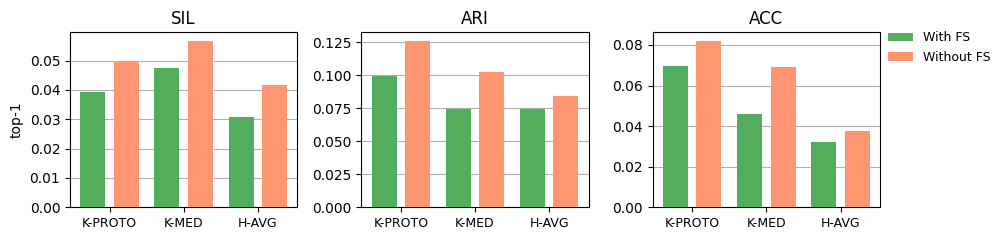

In [48]:
def show_impact_fs(results, savedir=None):
    colors = {
        "AMF-FS-KNN": "#52AD5D",
        # "AMF-AE-KNN": "#FF9671",
        "AMF-KNN": "#FF9671",
        # "AR": "#868686",
        "LB": "#AEAEAE",
        "RB": "#CFCFCF",
    }
    labels = {k: k for k in colors}
    labels["AMF-FS-KNN"] = "With FS"
    labels["AMF-KNN"] = "Without FS"

    model_names = ["AMF-FS-KNN", "AMF-KNN"] #, "MKNN", "MDTree", "PR-LR", "PR-KNN", "PR-DTree"

    fig = plt.figure(figsize=(9, 2.5))
    k = 1
    baselines = []
    for j, eval_metric in enumerate(["sil", "ari", "acc"]):
        y = {}
        plt.subplot(1, 3, j+1)
        for algorithm in results:
            res = results[algorithm][eval_metric]["scores"]
            best_scores = res["Oracle"][1]
            for model_name in model_names:
                if model_name not in y:
                    y[model_name] = []
                l = res[model_name][k]
                if eval_metric in ["sil"]:
                    v = (l+1)/(best_scores+1)
                elif eval_metric in ["acc"]:
                    v = (l)/(best_scores)
                elif eval_metric in ["ari"]:
                    v = (l+0.5)/(best_scores+0.5)
                y[model_name].append(1 - np.mean(v))

            for name in baselines:
                if name not in y:
                    y[name] = []
                l = res[name][1]
                if eval_metric in ["sil"]:
                    v = (l+1)/(best_scores+1)
                elif eval_metric in ["acc"]:
                    v = (l)/(best_scores)
                elif eval_metric in ["ari"]:
                    v = (l+0.5)/(best_scores+0.5)
                y[name].append(1 - np.mean(v))

        n_bar = len(y)
        w = 0.9/n_bar
        x = np.arange(len(results))
        boxes = []
        i = 0
        for model_name, values in y.items():
            # boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            # flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
            #                 linewidth=0)
            # medianprops = dict(color='black', linewidth=0.5)
            # meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            plt.bar(x+(i*w-(n_bar-1)*w/2), values, width=w*0.75, label=labels[model_name] if eval_metric=="sil" else None, color=colors[model_name], zorder=5)
            i+=1
        if j==0: plt.ylabel(f"top-{k}")
        # plt.ylim((0.85, 1.0))
        plt.xticks(x, [names[algo] for algo in results], rotation=0, fontsize=9)
        plt.grid(axis="y")
        plt.title(eval_metric.upper())
    plt.figlegend(fontsize=9, loc= "upper left", bbox_to_anchor= (0.98, 0.9), frameon=False)
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(os.path.join(savedir, f"impact_fs_top{k}.pdf"), bbox_inches='tight')
    plt.show()
        
    # fig = plt.figure(figsize=(9, 2.5))
    # k = 10
    # for j, eval_metric in enumerate(["sil", "ari", "acc"]):
    #     y = {}
    #     plt.subplot(1, 3, j+1)
    #     for algorithm in results:
    #         res = results[algorithm][eval_metric]["scores"]
    #         best_scores = res["Oracle"][1]
    #         for model_name in model_names:
    #             if model_name not in y:
    #                 y[model_name] = []
    #             l = res[model_name][k]
    #             if eval_metric in ["sil"]:
    #                 v = (l+1)/(best_scores+1)
    #             elif eval_metric in ["acc"]:
    #                 v = (l)/(best_scores)
    #             elif eval_metric in ["ari"]:
    #                 v = (l+0.5)/(best_scores+0.5)
    #             y[model_name].append(np.mean(v))

    #     n_bar = len(y)
    #     w = 0.9/n_bar
    #     x = np.arange(len(results))
    #     boxes = []
    #     i = 0
    #     for model_name, values in y.items():
    #         # boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
    #         # flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
    #         #                 linewidth=0)
    #         # medianprops = dict(color='black', linewidth=0.5)
    #         # meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
    #         plt.bar(x+(i*w-(n_bar-1)*w/2), values, width=w*0.75, label=labels[model_name] if eval_metric=="sil" else None, color=colors[model_name], zorder=5)
    #         i+=1
    #     if j==0: plt.ylabel(f"top-{k}")
    #     plt.ylim((0.9, 1.0))
    #     plt.xticks(x, [names[algo] for algo in results], rotation=0, fontsize=9)
    #     plt.grid(axis="y")
    #     plt.title(eval_metric.upper())
    # plt.figlegend(fontsize=9, loc= "upper left", bbox_to_anchor= (0.98, 0.9), frameon=False)
    # plt.tight_layout()
    # if savedir is not None:
    #     plt.savefig(os.path.join(savedir, f"impact_fs_top{k}.pdf"), bbox_inches='tight')
    # plt.show()
        
    # fig = plt.figure(figsize=(9, 2.5))
    # for j, eval_metric in enumerate(["sil", "ari", "acc"]):
    #     y = {}
    #     plt.subplot(1, 3, j+1)
    #     for algorithm in results:
    #         res = results[algorithm][eval_metric]["ndcg"]
    #         for model_name in model_names:
    #             if model_name not in y:
    #                 y[model_name] = []
    #             v = res[model_name][k]
    #             y[model_name].append(np.mean(v))

    #     n_bar = len(y)
    #     w = 0.8/n_bar
    #     x = np.arange(len(results))
    #     boxes = []
    #     i = 0
    #     for model_name, values in y.items():
    #         # boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
    #         # flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
    #         #                 linewidth=0)
    #         # medianprops = dict(color='black', linewidth=0.5)
    #         # meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
    #         plt.bar(x+(i*w-(n_bar-1)*w/2), values, width=w*0.75, label=labels[model_name] if eval_metric=="sil" else None, color=colors[model_name], zorder=5)
    #         i+=1
    #     if j==0: plt.ylabel(f"NDCG@{k}")
    #     plt.ylim((0.95, 1.0))
    #     plt.xticks(x, [names[algo] for algo in results], rotation=0, fontsize=9)
    #     plt.grid(axis="y")
    #     plt.title(eval_metric.upper())
        
    #     # if eval_metric=="sil":
    #     #     plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=10, loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=len(model_names)+len(baselines))
    # plt.figlegend(fontsize=9, loc= "upper left", bbox_to_anchor= (0.98, 0.9), frameon=False)
    # plt.tight_layout()
    # if savedir is not None:
    #     plt.savefig(os.path.join(savedir, f"impact_fs_ndcg{k}.pdf"), bbox_inches='tight')
    # plt.show()

show_impact_fs(results) #, savedir="imgs/"

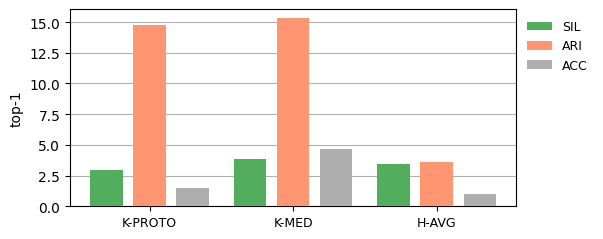

In [51]:
def show_impact_fs(results, savedir=None):
    colors = {
        "sil": "#52AD5D",
        # "AMF-AE-KNN": "#FF9671",
        "ari": "#FF9671",
        # "AR": "#868686",
        "acc": "#AEAEAE",
    }
    labels = {k: k for k in colors}
    labels["AMF-FS-KNN"] = "With FS"
    labels["AMF-KNN"] = "Without FS"

    model_names = ["AMF-FS-KNN", "AMF-KNN"] #, "MKNN", "MDTree", "PR-LR", "PR-KNN", "PR-DTree"

    fig = plt.figure(figsize=(6, 2.5))
    k = 1
    baselines = []
    y = {}
    for j, eval_metric in enumerate(["sil", "ari", "acc"]):
        y[eval_metric] = []
        for algorithm in results:
            Y = train_res[algorithm][eval_metric]["Y"]
            if eval_metric in ["acc", "purity"]:
                Yn = np.array([y/max(y) for y in Y])
                # Yn[Yn > 0] **= 4
                Yn[Yn <= 0] = -1
            elif eval_metric == "ari":
                Yn = np.array([(y+0.5)/max(y+0.5) for y in Y])
                Yn[Yn <= 0] = -1
            else:
                Yn = np.array([(y+1)/max(y+1) for y in Y])
                Yn[Yn <= 0] = -1

            l = [np.mean(1 - y[y>-1]) for i, y in enumerate(Yn)]
            x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 4)])
            list_indices = [
                [xr < np.mean(1 - y[y>-1]) <= x[r+1] for i, y in enumerate(Yn)]
                for r, xr in enumerate(x[:-1])
            ] #

            res = results[algorithm][eval_metric]["scores"]
            best_scores = res["Oracle"][1]
            l1 = res[model_names[0]][k]
            l2 = res[model_names[1]][k]
            if eval_metric in ["sil"]:
                l1 = (l1+1)/(best_scores+1)
                l2 = (l2+1)/(best_scores+1)
            elif eval_metric in ["acc"]:
                l1 = (l1)/(best_scores)
                l2 = (l2)/(best_scores)
            elif eval_metric in ["ari"]:
                l1 = (l1+0.5)/(best_scores+0.5)
                l2 = (l2+0.5)/(best_scores+0.5)
            v = (l1 - l2)/l2
            y[eval_metric].append(np.mean(v)*100)

    n_bar = len(y)
    w = 0.9/n_bar
    x = np.arange(len(results))
    boxes = []
    i = 0
    for eval_metric, values in y.items():
        # boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
        # flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
        #                 linewidth=0)
        # medianprops = dict(color='black', linewidth=0.5)
        # meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
        plt.bar(x+(i*w-(n_bar-1)*w/2), values, width=w*0.75, label=eval_metric.upper(), color=colors[eval_metric], zorder=5)
        i+=1
    plt.ylabel(f"top-{k}")
    # plt.ylim((0.85, 1.0))
    plt.xticks(x, [names[algo] for algo in results], rotation=0, fontsize=9)
    plt.grid(axis="y")

    plt.legend(fontsize=9, loc= "upper left", bbox_to_anchor= (1, 1), frameon=False)
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(os.path.join(savedir, f"impact_fs_top{k}.pdf"), bbox_inches='tight')
    plt.show()
        
    # fig = plt.figure(figsize=(9, 2.5))
    # k = 10
    # for j, eval_metric in enumerate(["sil", "ari", "acc"]):
    #     y = {}
    #     plt.subplot(1, 3, j+1)
    #     for algorithm in results:
    #         res = results[algorithm][eval_metric]["scores"]
    #         best_scores = res["Oracle"][1]
    #         for model_name in model_names:
    #             if model_name not in y:
    #                 y[model_name] = []
    #             l = res[model_name][k]
    #             if eval_metric in ["sil"]:
    #                 v = (l+1)/(best_scores+1)
    #             elif eval_metric in ["acc"]:
    #                 v = (l)/(best_scores)
    #             elif eval_metric in ["ari"]:
    #                 v = (l+0.5)/(best_scores+0.5)
    #             y[model_name].append(np.mean(v))

    #     n_bar = len(y)
    #     w = 0.9/n_bar
    #     x = np.arange(len(results))
    #     boxes = []
    #     i = 0
    #     for model_name, values in y.items():
    #         # boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
    #         # flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
    #         #                 linewidth=0)
    #         # medianprops = dict(color='black', linewidth=0.5)
    #         # meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
    #         plt.bar(x+(i*w-(n_bar-1)*w/2), values, width=w*0.75, label=labels[model_name] if eval_metric=="sil" else None, color=colors[model_name], zorder=5)
    #         i+=1
    #     if j==0: plt.ylabel(f"top-{k}")
    #     plt.ylim((0.9, 1.0))
    #     plt.xticks(x, [names[algo] for algo in results], rotation=0, fontsize=9)
    #     plt.grid(axis="y")
    #     plt.title(eval_metric.upper())
    # plt.figlegend(fontsize=9, loc= "upper left", bbox_to_anchor= (0.98, 0.9), frameon=False)
    # plt.tight_layout()
    # if savedir is not None:
    #     plt.savefig(os.path.join(savedir, f"impact_fs_top{k}.pdf"), bbox_inches='tight')
    # plt.show()
        
    # fig = plt.figure(figsize=(9, 2.5))
    # for j, eval_metric in enumerate(["sil", "ari", "acc"]):
    #     y = {}
    #     plt.subplot(1, 3, j+1)
    #     for algorithm in results:
    #         res = results[algorithm][eval_metric]["ndcg"]
    #         for model_name in model_names:
    #             if model_name not in y:
    #                 y[model_name] = []
    #             v = res[model_name][k]
    #             y[model_name].append(np.mean(v))

    #     n_bar = len(y)
    #     w = 0.8/n_bar
    #     x = np.arange(len(results))
    #     boxes = []
    #     i = 0
    #     for model_name, values in y.items():
    #         # boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
    #         # flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
    #         #                 linewidth=0)
    #         # medianprops = dict(color='black', linewidth=0.5)
    #         # meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
    #         plt.bar(x+(i*w-(n_bar-1)*w/2), values, width=w*0.75, label=labels[model_name] if eval_metric=="sil" else None, color=colors[model_name], zorder=5)
    #         i+=1
    #     if j==0: plt.ylabel(f"NDCG@{k}")
    #     plt.ylim((0.95, 1.0))
    #     plt.xticks(x, [names[algo] for algo in results], rotation=0, fontsize=9)
    #     plt.grid(axis="y")
    #     plt.title(eval_metric.upper())
        
    #     # if eval_metric=="sil":
    #     #     plt.figlegend([box["boxes"][0] for box in boxes], labels.values(), fontsize=10, loc= "lower center", bbox_to_anchor= (0.5, 1), frameon=False, ncol=len(model_names)+len(baselines))
    # plt.figlegend(fontsize=9, loc= "upper left", bbox_to_anchor= (0.98, 0.9), frameon=False)
    # plt.tight_layout()
    # if savedir is not None:
    #     plt.savefig(os.path.join(savedir, f"impact_fs_ndcg{k}.pdf"), bbox_inches='tight')
    # plt.show()

show_impact_fs(results) #, savedir="imgs/"

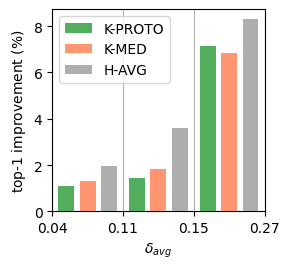

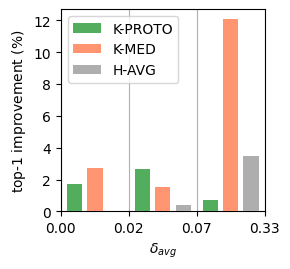

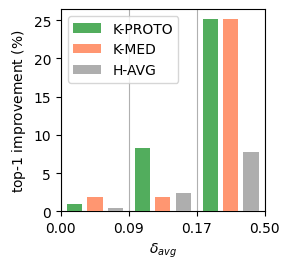

In [72]:
def show_impact_fs_delta(results, eval_metric="sil", savedir=None, list_algo=None):
    model_names = ["AMF-FS-KNN", "AR"]
    color = "#52AD5D"
    colors = {
        "kprototypes": "#52AD5D",
        # "AMF-AE-KNN": "#FF9671",
        "fasterpam": "#FF9671",
        # "AR": "#868686",
        "haverage": "#AEAEAE",
    }

    linestyle = {
        "kprototypes": "-o",
        "fasterpam": "--*",
        "haverage": "--s",
    }
    k = 1
    for eval_metric in ["sil", "acc", "ari"]:
        y = {}
        yerr = {}
        plt.figure(figsize=(3, 2.8))
        for algorithm in results:
            y[algorithm] = []
            yerr[algorithm] = []
            Y = train_res[algorithm][eval_metric]["Y"]
            if eval_metric in ["acc", "purity"]:
                Yn = np.array([y/max(y) for y in Y])
                # Yn[Yn > 0] **= 4
                Yn[Yn <= 0] = -1
            elif eval_metric == "ari":
                Yn = np.array([(y+0.5)/max(y+0.5) for y in Y])
                Yn[Yn <= 0] = -1
            else:
                Yn = np.array([(y+1)/max(y+1) for y in Y])
                Yn[Yn <= 0] = -1

            res = results[algorithm][eval_metric]["scores"]
            best_scores = res["Oracle"][1]
            l = [np.mean(1 - y[y>-1]) for i, y in enumerate(Yn)]
            x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 4)])
            
            x[0] -= 1e-4
            list_indices = [
                [xr < np.mean(1 - y[y>-1]) <= x[r+1] for i, y in enumerate(Yn)]
                for r, xr in enumerate(x[:-1])
            ] #
            l1 = res[model_names[0]][k]
            l2 = res[model_names[1]][k]
            if eval_metric in ["sil"]:
                l1 = (l1+1)/(best_scores+1)
                l2 = (l2+1)/(best_scores+1)
            elif eval_metric in ["acc"]:
                l1 = (l1)/(best_scores)
                l2 = (l2)/(best_scores)
            elif eval_metric in ["ari"]:
                l1 = (l1+0.5)/(best_scores+0.5)
                l2 = (l2+0.5)/(best_scores+0.5)
            v = (l1 - l2)/l2
            for indices in list_indices:
                y[algorithm].append(np.mean(v[indices])*100)
                yerr[algorithm].append(np.std(v[indices])*100)

        z = np.arange(len(x))
        n_bar = len(y)
        w = 0.9/n_bar
        boxes = []
        i = 0
        for algorithm, values in y.items():
            # boxprops = dict(linewidth=0.5, facecolor=colors[model_name], alpha=1) # 726686 
            # flierprops = dict(marker='o', markerfacecolor=colors[model_name], markeredgecolor='none', markersize=2, alpha=0.5,
            #                 linewidth=0)
            # medianprops = dict(color='black', linewidth=0.5)
            # meanprops = dict(marker='*', markerfacecolor='red', markeredgecolor='none', linewidth=0)
            plt.bar(z[:-1]+(i*w-(n_bar-1)*w/2)+0.5, values, width=w*0.75, label=names[algorithm], color=colors[algorithm], zorder=5)
            i+=1

        plt.xlim((z[0], z[-1]))
        plt.ylabel(f"top-${k}$ improvement (%)")
        plt.xticks(z, [f"{max(0, val):.2f}" for val in x])
        plt.grid(axis="x")
        plt.xlabel("$\delta_{avg}$")

        plt.legend(fontsize=10)

        plt.tight_layout()
        if savedir is not None:
            plt.savefig(os.path.join(savedir, f"impact_fs_delta_{eval_metric}.pdf"), bbox_inches='tight')
        plt.show()

show_impact_fs_delta(results, savedir="imgs") #

[57, 56, 57]
[58, 57, 58]
[58, 57, 58]


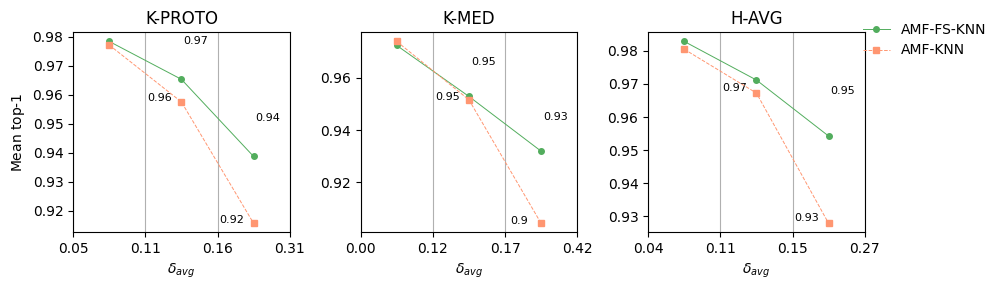

[29, 28, 28]
[27, 27, 27]
[32, 31, 31]


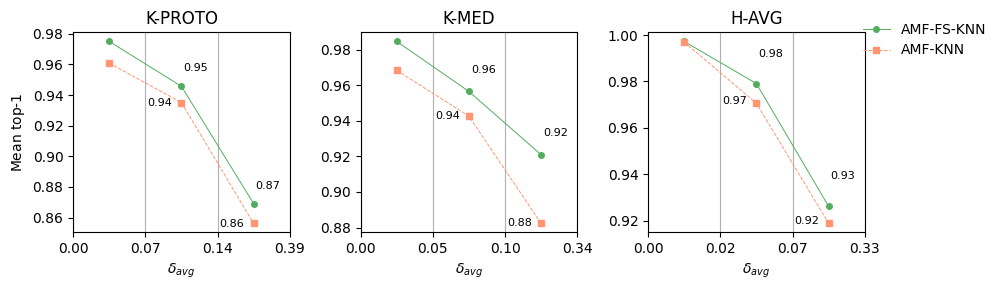

[29, 28, 28]
[27, 27, 27]
[32, 31, 31]


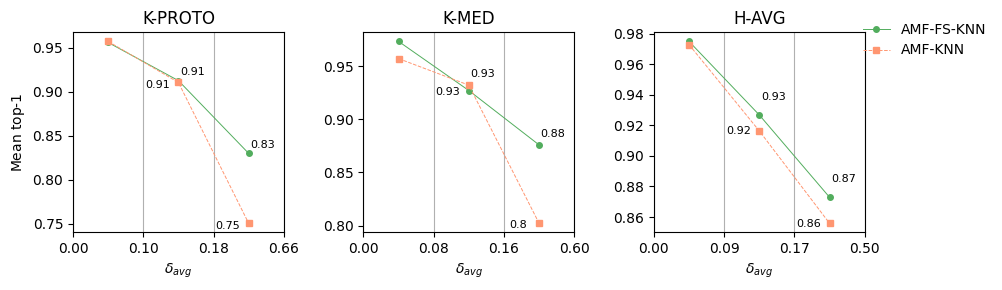

In [50]:
def show_results_delta(results, eval_metric="sil", savedir=None, list_algo=None):
    model_names = ["AMF-FS-KNN", "AMF-KNN"]

    colors = {
        "AMF-FS-KNN": "#52AD5D",
        "AMF-KNN": "#FF9671",
    }

    linestyle = {
        "AMF-FS-KNN": "-o",
        "AMF-KNN": "--s",
    }
    for eval_metric in ["sil", "acc", "ari"]:
        plt.figure(figsize=(3*3, 3))
        j = 1
        for algorithm in results:
            plt.subplot(1, 3, j)
            Y = train_res[algorithm][eval_metric]["Y"]
            if eval_metric in ["acc", "purity"]:
                Yn = np.array([y/max(y) for y in Y])
                # Yn[Yn > 0] **= 4
                Yn[Yn <= 0] = -1
            elif eval_metric == "ari":
                Yn = np.array([(y+0.5)/max(y+0.5) for y in Y])
                Yn[Yn <= 0] = -1
            else:
                Yn = np.array([(y+1)/max(y+1) for y in Y])
                Yn[Yn <= 0] = -1

            res = results[algorithm][eval_metric]["scores"]
            
            best_scores = res["Oracle"][1]
            lb_scores = res["LB"][1]
            l = [np.mean(1 - y[y>-1]) for i, y in enumerate(Yn)]
            x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 4)])
            
            x[0] -= 1e-4
            diff = 0.025
            list_indices = [
                [xr < np.mean(1 - y[y>-1]) <= x[r+1] for i, y in enumerate(Yn)]
                for r, xr in enumerate(x[:-1])
            ] #

            k=1
            y = {}
            yerr = {}
            print([sum(indices) for indices in list_indices])
            for model_name in model_names:
                y[model_name] = []
                yerr[model_name] = []
                scores = res[model_name][k]
                for i, indices in enumerate(list_indices):
                    if eval_metric in ["sil"]:
                        ln = ((scores+1)/(best_scores+1))[indices]
                    elif eval_metric in ["ari"]:
                        ln = ((scores+0.5)/(best_scores+0.5))[indices]
                    else:
                        ln = (scores/best_scores)[indices]
                    v = np.mean(ln)
                    std = np.std(ln)
                    y[model_name].append(v)
                    yerr[model_name].append(std)

            n_bar = len(y)
            w = 0.8/n_bar
            z = np.arange(len(x))
            i = 0
            max_ = np.zeros(len(list_indices))
            min_ = np.ones(len(list_indices))*100
            for model_name, values in y.items():
                max_ = np.maximum(max_, values)
                min_ = np.minimum(min_, values)
                plt.plot(z[:-1]+0.5, values, linestyle[model_name], linewidth=0.7, c=colors[model_name], label=model_name if j==1 else None, markersize=4, zorder=10)
                i += 1

            for ind, val in enumerate(list_indices):
                if ind >= 1:
                    plt.annotate(f"{max_[ind]:.2g}", (z[ind]+0.7, max_[ind]+0.015), fontsize=8, ha="center", va="top")
                    plt.annotate(f"{min_[ind]:.2g}", (z[ind]+0.2, min_[ind]+0.003), fontsize=8, ha="center", va="top")

            plt.xlim((z[0], z[-1]))
            if j == 1: plt.ylabel(f"Mean top-${k}$")
            plt.xticks(z, [f"{max(0, val):.2f}" for val in x])
            plt.grid(axis="x")
            plt.xlabel("$\delta_{avg}$")
            plt.title(names[algorithm])

            j += 1

        plt.figlegend(fontsize=10, loc= "upper left", bbox_to_anchor= (0.95, 0.95), frameon=False)

        plt.tight_layout()
        if savedir is not None:
            plt.savefig(os.path.join(savedir, f"results_delta_{algo}.pdf"), bbox_inches='tight')
        plt.show()

show_results_delta(results)

In [13]:
eval_metric = 'sil'
l1 = set(["_".join(s.split("_")[1:]) for s in train_res["kprototypes"][eval_metric]["selected_features"]])
l2 = set(["_".join(s.split("_")[1:]) for s in train_res["fasterpam"][eval_metric]["selected_features"]])
l3 = set(["_".join(s.split("_")[1:]) for s in train_res["haverage"][eval_metric]["selected_features"]])
intersection = l1.intersection(l2).intersection(l3)
print(len(intersection), intersection)
print(len(l1.difference(intersection)), l1.difference(intersection))
print(len(l2.difference(intersection)), l2.difference(intersection))
print(len(l3.difference(intersection)), l3.difference(intersection))

11 {'instances', 'card_cat_att', 'std_freq_cat_att', 'entropy_cat_att', 'std_squared_num_att', 'means_num_att', 'std_internal_product_num_att', 'mutual_info_cat_att', 'std_num_att', 'means_internal_product_num_att', 'covariance'}
2 {'features', 'means_squared_num_att'}
1 {'means_squared_num_att'}
2 {'on_cat', 'features'}


[41, 29, 34, 32, 34]
[41, 29, 35, 35, 33]
[41, 29, 35, 35, 33]


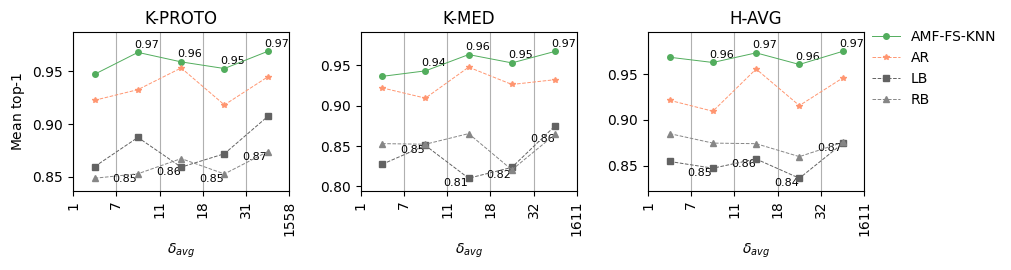

[17, 19, 16, 16, 17]
[17, 17, 16, 15, 16]
[21, 22, 13, 20, 18]


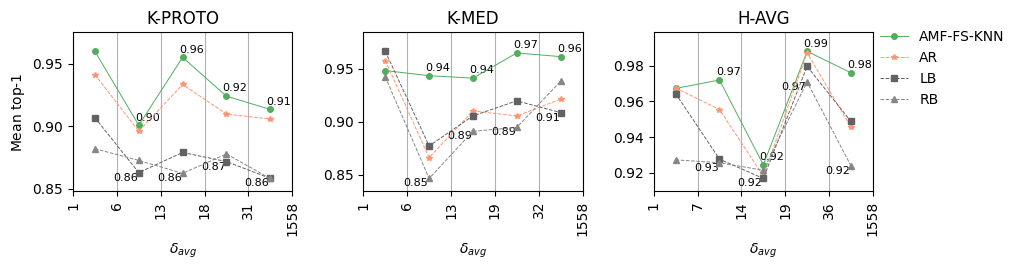

[17, 19, 16, 16, 17]
[17, 17, 16, 15, 16]
[21, 22, 13, 20, 18]


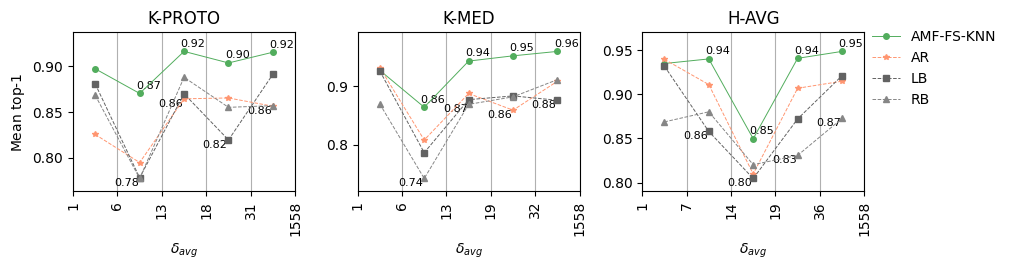

In [26]:
def show_results_delta(results, eval_metric="sil", savedir=None, list_algo=None):
    model_names = ["AMF-FS-KNN", "AR"]

    colors = {
        "AMF-FS-KNN": "#52AD5D",
        "AR": "#FF9671",
        "LB": "#626262",
        "RB": "#868686",
        # "ARB": "#AFAFAF"
    }

    linestyle = {
        "AMF-FS-KNN": "-o",
        "LB": "--s",
        "RB": "--^",
        "AR": "--*"
    }
    for eval_metric in ["sil", "acc", "ari"]:
        plt.figure(figsize=(3*3, 2.8))
        j = 1
        for algorithm in results:
            plt.subplot(1, 3, j)
            Y = train_res[algorithm][eval_metric]["Y"]
            n_features = train_res[algorithm][eval_metric]["meta_dataset"][0].n_features.to_numpy()
            if eval_metric in ["acc", "purity"]:
                Yn = np.array([y/max(y) for y in Y])
                # Yn[Yn > 0] **= 4
                Yn[Yn <= 0] = -1
            elif eval_metric == "ari":
                Yn = np.array([(y+0.5)/max(y+0.5) for y in Y])
                Yn[Yn <= 0] = -1
            else:
                Yn = np.array([(y+1)/max(y+1) for y in Y])
                Yn[Yn <= 0] = -1

            res = results[algorithm][eval_metric]["scores"]
            
            best_scores = res["Oracle"][1]
            lb_scores = res["LB"][1]
            l = n_features
            x = np.array([np.quantile(l, q) for q in np.linspace(0, 1, 6)])
            
            x[0] -= 1e-4
            diff = 0.025
            list_indices = [
                [xr < n <= x[r+1] for i, n in enumerate(n_features)]
                for r, xr in enumerate(x[:-1])
            ] #

            k=1
            baselines = ["LB", "RB"]
            y = {}
            yerr = {}
            print([sum(indices) for indices in list_indices])
            for model_name in model_names:
                y[model_name] = []
                yerr[model_name] = []
                scores = res[model_name][k]
                for i, indices in enumerate(list_indices):
                    if eval_metric in ["sil"]:
                        ln = ((scores+1)/(best_scores+1))[indices]
                    elif eval_metric in ["ari"]:
                        ln = ((scores+0.5)/(best_scores+0.5))[indices]
                    else:
                        ln = (scores/best_scores)[indices]
                    v = np.mean(ln)
                    std = np.std(ln)
                    y[model_name].append(v)
                    yerr[model_name].append(std)

            for name in baselines:
                y[name] = []
                yerr[name] = []
                scores = res[name][1]
                for i, indices in enumerate(list_indices):
                    if eval_metric in ["sil"]:
                        ln = ((scores+1)/(best_scores+1))[indices]
                    elif eval_metric in ["ari"]:
                        ln = ((scores+0.5)/(best_scores+0.5))[indices]
                    else:
                        ln = (scores/best_scores)[indices]
                    v = np.mean(ln)
                    std = np.std(ln)
                    y[name].append(v)
                    yerr[name].append(std)

            n_bar = len(y)
            w = 0.8/n_bar
            z = np.arange(len(x))
            i = 0
            max_ = np.zeros(len(list_indices))
            min_ = np.ones(len(list_indices))*100
            for model_name, values in y.items():
                max_ = np.maximum(max_, values)
                min_ = np.minimum(min_, values)
                plt.plot(z[:-1]+0.5, values, linestyle[model_name], linewidth=0.7, c=colors[model_name], label=model_name if j==1 else None, markersize=4, zorder=10)
                i += 1

            # delta_x = max(x) - min(x)
            delta_y = max(max_) - min(min_)
            for ind, val in enumerate(list_indices):
                if ind >= 1:
                    plt.annotate(f"{max_[ind]:.02f}", (z[ind]+0.7, max_[ind]+delta_y*0.1), fontsize=8, ha="center", va="top")
                    plt.annotate(f"{min_[ind]:.02f}", (z[ind]+0.2, min_[ind]), fontsize=8, ha="center", va="top")

            plt.xlim((z[0], z[-1]))
            plt.ylim((min(min_) - delta_y*0.1, max(max_) + delta_y*0.15))
            if j == 1: plt.ylabel(f"Mean top-${k}$")
            plt.xticks(z, [f"{max(0, int(val))}" for val in x], rotation="vertical")
            plt.grid(axis="x")
            plt.xlabel("$\delta_{avg}$")
            plt.title(names[algorithm])

            j += 1

        plt.figlegend(fontsize=10, loc= "upper left", bbox_to_anchor= (0.97, 0.92), frameon=False)

        plt.tight_layout()
        if savedir is not None:
            plt.savefig(os.path.join(savedir, f"results_delta_{algo}.pdf"), bbox_inches='tight')
        plt.show()

show_results_delta(results)

In [33]:
from scipy.stats import wilcoxon, ttest_rel

model_name = "AMF-FS-KNN"
baselines = ["AR", "LB", "RB"]
k = 1
for name in baselines:
    y_1 = {}
    for eval_metric in ["sil", "ari", "acc"]:
        y_1[eval_metric.upper()] = {}
        for algorithm in results:
            res = results[algorithm][eval_metric]["scores"]
            baseline_scores = res[name][k]
            scores = res[model_name][k]
            s, p = wilcoxon(scores, baseline_scores, alternative="greater")
            y_1[eval_metric.upper()][f"{algorithm[0]}-{name}"] = f"{p:.3f}"
    print(pd.DataFrame.from_dict(y_1, orient='index'))

baselines = ["AR"]
y_10 = {}
k = 10
for eval_metric in ["sil", "ari", "acc"]:
    y_10[eval_metric.upper()] = {}
    for algorithm in results:
        res = results[algorithm][eval_metric]["scores"]
        for name in baselines:
            baseline_scores = res[name][k]
            scores = res[model_name][k]
            s, p = wilcoxon(scores, baseline_scores, alternative="greater")
            y_10[eval_metric.upper()][f"{algorithm[0]}-{name}"] = f"{p:.3f}"
print(pd.DataFrame.from_dict(y_10, orient='index'))

y_ndcg = {}
k = 10
for eval_metric in ["sil", "ari", "acc"]:
    y_ndcg[eval_metric.upper()] = {}
    for algorithm in results:
        res = results[algorithm][eval_metric]["ndcg"]
        for name in baselines:
            baseline_scores = res[name][k]
            scores = res[model_name][k]
            s, p = wilcoxon(scores, baseline_scores, alternative="greater")
            y_ndcg[eval_metric.upper()][f"{algorithm[0]}-{name}"] = f"{p:.3f}"
print(pd.DataFrame.from_dict(y_ndcg, orient='index'))

      k-AR   f-AR   h-AR
SIL  0.000  0.000  0.000
ARI  0.001  0.001  0.001
ACC  0.001  0.000  0.002
      k-LB   f-LB   h-LB
SIL  0.000  0.000  0.000
ARI  0.000  0.000  0.000
ACC  0.000  0.000  0.002
      k-RB   f-RB   h-RB
SIL  0.000  0.000  0.000
ARI  0.002  0.000  0.000
ACC  0.000  0.000  0.000
      k-AR   f-AR   h-AR
SIL  0.000  0.000  0.000
ARI  0.007  0.000  0.918
ACC  0.046  0.001  0.819
      k-AR   f-AR   h-AR
SIL  0.000  0.000  0.000
ARI  0.008  0.006  0.009
ACC  0.022  0.002  0.166
